In [11]:
using FCA, Combinatorics, LinearAlgebra, Statistics, MAT, Plots, StatsBase
gr()

┌ Info: Precompiling MAT [23992714-dd62-5051-b70f-ba57cb901cac]
└ @ Base loading.jl:1192


Plots.GRBackend()

## DCT and DST orthogonal matrix

In [12]:
function dctmtx(n)
    cc, rr = [j for i = 0: n - 1, j = 0: n-1], [i for i = 0: n - 1, j = 0: n-1]
    c = sqrt(2 / n) * cos.(pi * (2*cc .+ 1) .* rr / (2 * n));
    c[1,:] = c[1,:] / sqrt(2);
    return c
end

dctmtx (generic function with 1 method)

In [13]:
function dstmtx(n)
    cc, rr = [j for i = 0: n - 1, j = 0: n-1], [i for i = 0: n - 1, j = 0: n-1]
    c = sqrt(2 / n) * sin.(pi * (2*cc .+ 1) .* (rr .+ 1) / (2 * n));
    c[n,:] = c[n,:] / sqrt(2);
    return c
end

dstmtx (generic function with 1 method)

## Image denoise

In [ ]:
function trial(N, lambda)
    # generate image 
    M = Int(ceil(N/lambda));
    U,V = dstmtx(N), dctmtx(M);
    D = Diagonal(map(x -> (x - 1)^4, range(1/2/N, length=N, stop=1-1/2/N)))
    D = hcat(D, zeros(N, M - N))
    image = U*D*V';
    image = free_whiten([image]; mat = "rec")[1][1];
    
    # generate noise
    noise = randn(N,M);
    noise = free_whiten([noise]; mat = "rec")[1][1];
    
    X = [image, noise];
    Q = [1 1; -1 1]/sqrt(2);
    
    Y = Q*X;
    
    # use kurtosis-based FCA
    Qinv_kurt, _ = freecf(Y; mat = "rec", obj = "kurt", opt = "orth");
    err_kurt = err_pd(pinv(Qinv_kurt)*Q)
    
    # use entropy-based FCA
    Qinv_ent, _ = freecf(Y; mat = "rec", obj = "ent", opt = "orth");
    err_ent = err_pd(pinv(Qinv_ent)*Q)
    
    # use kurtosis-based ICA
    y = [vec(Yi) for Yi in Y]
    Qinv_kurt_ica, _ = icf(y; obj = "kurt", opt = "orth")
    err_ica_kurt = err_pd(pinv(Qinv_kurt_ica)*Q)
    
    # use entropy-based ICA
    Qinv_ent_ica, _ = icf(y; obj = "ent", opt = "orth")
    err_ica_ent = err_pd(pinv(Qinv_ent_ica)*Q)
    
    return err_kurt, err_ent, err_ica_kurt, err_ica_ent
end

In [ ]:
trialsize = 200;
Nlist = [Int64(ceil(2^pow)) for pow in collect(range(7, length = 5, stop = 9))]
lambda = 4/5;
err_kurt_record = zeros(size(Nlist, 1), trialsize);
err_ent_record = zeros(size(Nlist, 1), trialsize);
err_ica_kurt_record = zeros(size(Nlist, 1), trialsize);
err_ica_ent_record = zeros(size(Nlist, 1), trialsize);

for trial_idx in 1: trialsize
    @show trial_idx
    for N_idx in 1:length(Nlist)
        N = Nlist[N_idx]
        err_kurt, err_ent, err_ica_kurt, err_ica_ent = trial(N, lambda)
        err_kurt_record[N_idx, trial_idx] = err_kurt
        err_ent_record[N_idx, trial_idx] = err_ent
        err_ica_kurt_record[N_idx, trial_idx] = err_ica_kurt
        err_ica_ent_record[N_idx, trial_idx] = err_ica_ent
    end
end

┌ Warning: scale log is unsupported with Plots.GRBackend().  Choose from: Symbol[:identity, :log10]
└ @ Plots /Users/haowurm/.julia/packages/Plots/47Tik/src/args.jl:1170
┌ Warning: scale log is unsupported with Plots.GRBackend().  Choose from: Symbol[:identity, :log10]
└ @ Plots /Users/haowurm/.julia/packages/Plots/47Tik/src/args.jl:1170
┌ Warning: scale log is unsupported with Plots.GRBackend().  Choose from: Symbol[:identity, :log10]
└ @ Plots /Users/haowurm/.julia/packages/Plots/47Tik/src/args.jl:1170
┌ Warning: scale log is unsupported with Plots.GRBackend().  Choose from: Symbol[:identity, :log10]
└ @ Plots /Users/haowurm/.julia/packages/Plots/47Tik/src/args.jl:1170


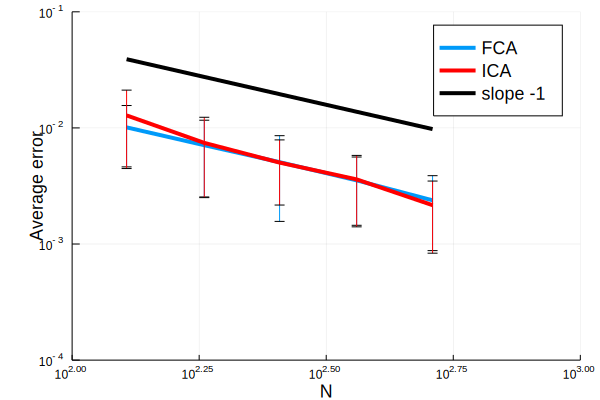

In [39]:
p1 = plot(Nlist, mean(err_kurt_record; dims = 2), 
        yerror = std(err_kurt_record; dims = 2),
        xscale = :log,
        yscale = :log,
        xlabel = "N",
        guidefont = 12,
        ylabel = "Average error",
        grid = :on,
        label = "FCA",
        xlim = (10^2,10^3),
        ylim = (10^(-4), 10^(-1)),
        linewidth = 4,
        legendfontsize = 12)

plot!(Nlist, mean(err_ica_kurt_record; dims = 2), 
        yerror = std(err_ica_kurt_record; dims = 2),
        xscale = :log,
        yscale = :log,
        grid = :on,
        label = "ICA",
        xlim = (10^2,10^3),
        ylim = (10^(-4), 10^(-1)),
        linewidth = 4,
        color = :red)

plot!(Nlist, 5*(Nlist.^(-1)),
        linewidth = 4,
        color = :black,
        label = "slope -1")

P = Plot{Plots.GRBackend() n=6}


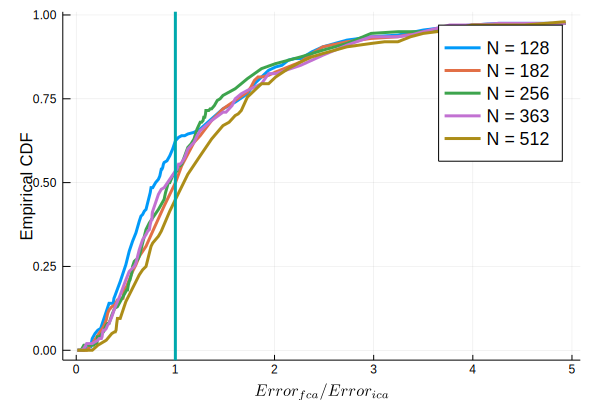

In [29]:
rv = err_kurt_record[1,:]./err_ica_kurt_record[1,:]
cdfrv = ecdf(rv)
P = plot(x -> cdfrv(x), 0, 5, xlabel = "\$Error_{fca}/Error_{ica}\$", 
    ylabel = "Empirical CDF", label = "N = $(Nlist[1])", linewidth = 3, 
    legendfontsize = 12)

for i = 2: 5
    rv = err_kurt_record[i,:]./err_ica_kurt_record[i,:]
    cdfrv = ecdf(rv)
    plot!(x -> cdfrv(x), 0, 5, xlabel = "\$Error_{fca}/Error_{ica}\$", 
        ylabel = "Empirical CDF", label = "N = $(Nlist[i])", linewidth = 3)
end

vline!([1], label = "", linewidth = 3)
@show P

┌ Warning: scale log is unsupported with Plots.GRBackend().  Choose from: Symbol[:identity, :log10]
└ @ Plots /Users/haowurm/.julia/packages/Plots/47Tik/src/args.jl:1170
┌ Warning: scale log is unsupported with Plots.GRBackend().  Choose from: Symbol[:identity, :log10]
└ @ Plots /Users/haowurm/.julia/packages/Plots/47Tik/src/args.jl:1170
┌ Warning: scale log is unsupported with Plots.GRBackend().  Choose from: Symbol[:identity, :log10]
└ @ Plots /Users/haowurm/.julia/packages/Plots/47Tik/src/args.jl:1170
┌ Warning: scale log is unsupported with Plots.GRBackend().  Choose from: Symbol[:identity, :log10]
└ @ Plots /Users/haowurm/.julia/packages/Plots/47Tik/src/args.jl:1170


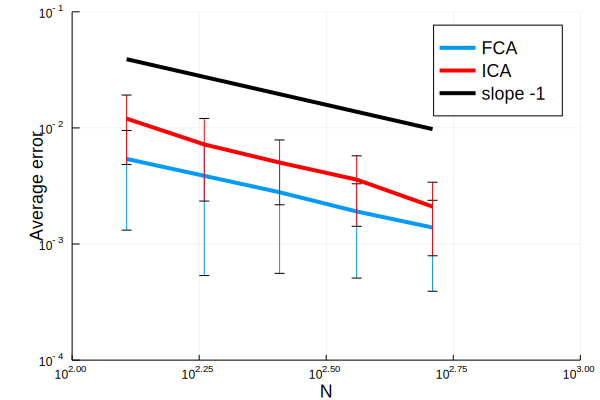

In [44]:
p1 = plot(Nlist, mean(err_ent_record; dims = 2), 
        yerror = std(err_ent_record; dims = 2),
        xscale = :log,
        yscale = :log,
        xlabel = "N",
        guidefont = 12,
        ylabel = "Average error",
        grid = :on,
        label = "FCA",
        xlim = (10^2,10^3),
        ylim = (10^(-4), 10^(-1)),
        linewidth = 4,
        legendfontsize = 12)

plot!(Nlist, mean(err_ica_ent_record; dims = 2), 
        yerror = std(err_ica_ent_record; dims = 2),
        xscale = :log,
        yscale = :log,
        grid = :on,
        label = "ICA",
        xlim = (10^2,10^3),
        ylim = (10^(-4), 10^(-1)),
        linewidth = 4,
        color = :red)

plot!(Nlist, 5*(Nlist.^(-1)),
        linewidth = 4,
        color = :black,
        label = "slope -1")

P = Plot{Plots.GRBackend() n=6}


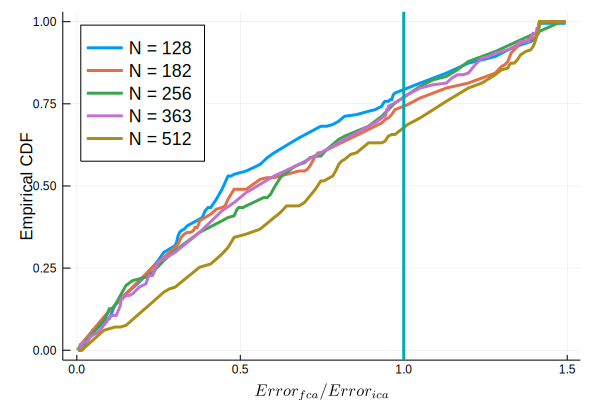

In [47]:
rv = err_ent_record[1,:]./err_ica_ent_record[1,:]
cdfrv = ecdf(rv)
P = plot(x -> cdfrv(x), 0, 1.5, xlabel = "\$Error_{fca}/Error_{ica}\$", 
    ylabel = "Empirical CDF", label = "N = $(Nlist[1])", linewidth = 3, 
    legendfontsize = 12, legend=:topleft)

for i = 2: 5
    rv = err_ent_record[i,:]./err_ica_ent_record[i,:]
    cdfrv = ecdf(rv)
    plot!(x -> cdfrv(x), 0, 1.5, xlabel = "\$Error_{fca}/Error_{ica}\$", 
        ylabel = "Empirical CDF", label = "N = $(Nlist[i])", linewidth = 3, 
    legendfontsize = 12)
end

vline!([1], label = "", linewidth = 3)
@show P